In [1]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import qctrlvisualizer as qv
import qutip as qt
from scipy.optimize import minimize, OptimizeResult


@dataclass
class OptimizationResult:
    result: OptimizeResult
    times: npt.NDArray[np.float64]
    params: npt.NDArray[np.float64]
    pulse: npt.NDArray[np.complex128]

    def plot(self):
        pulse = np.append(self.pulse, self.pulse[-1])
        plt.step(self.times, np.real(pulse), where="post", label="I")
        plt.step(self.times, np.imag(pulse), where="post", label="Q")
        plt.grid(color="gray", linestyle="--", alpha=0.2)
        plt.legend()
        plt.show()


@dataclass
class SimulationResult:
    times: npt.NDArray[np.float64]
    unitaries: list[qt.Qobj]
    states: list[qt.Qobj]
    infidelities: list[float]

    @property
    def dimension(self) -> int:
        return self.states[0].shape[0]

    @property
    def populations(self) -> npt.NDArray:
        return np.abs(np.array(self.states).squeeze()) ** 2

    def display_bloch_sphere(self):
        states = np.array(self.states).squeeze()
        qv.display_bloch_sphere(states[:, :2])

    def plot_populations(self):
        qv.plot_population_dynamics(
            sample_times=self.times,
            populations={
                rf"$|{k}\rangle$": self.populations[:, k] for k in range(self.dimension)
            },
        )

    def print_final_populations(self):
        population = self.populations[-1]
        for k in range(self.dimension):
            print(f"|{k}> : {population[k]:>6.2%}")

    def plot_unitary_infidelities(self):
        plt.plot(self.times, self.infidelities)
        plt.grid(color="gray", linestyle="--", alpha=0.2)
        plt.ylim(0, 1)


class PulseOptimizer:
    def __init__(
        self,
        dimension: int,
        detuning: float,
        anharmonicity: float,
        segment_count: int,
        segment_width: float,
    ):
        self.dimension = dimension
        self.detuning = detuning
        self.anharmonicity = anharmonicity
        self.segment_count = segment_count
        self.segment_width = segment_width
        self.duration = segment_count * segment_width
        self.a = qt.destroy(self.dimension)
        self.ad = self.a.dag()
        self.H_sys = self.system_hamiltonian()

    def system_hamiltonian(self) -> qt.Qobj:
        omega = 2 * np.pi * self.detuning
        alpha = 2 * np.pi * self.anharmonicity
        a = self.a
        ad = self.ad
        H_sys = omega * ad * a + 0.5 * alpha * ad * ad * a * a
        return H_sys

    def pwc_unitary(self, value: complex, duration: float) -> qt.Qobj:
        H_ctrl = 0.5 * (self.ad * value + self.a * np.conj(value))
        H = self.H_sys + H_ctrl
        U = (-1j * H * duration).expm()
        return U

    def objective_function(self, params: npt.NDArray[np.float64]) -> float:
        pulse = self.params_to_pulse(params)
        U = qt.qeye(self.dimension)
        for value in pulse:
            U = self.pwc_unitary(value, self.segment_width) * U
        return self.unitary_infidelity(U, self.target_unitary)

    def unitary_infidelity(self, U1: qt.Qobj, U2: qt.Qobj) -> float:
        return 1 - np.abs((U1.dag() * U2).tr() / self.dimension) ** 2

    def random_params(self) -> npt.NDArray[np.float64]:
        return np.random.uniform(-1, 1, 2 * self.segment_count)

    def params_to_pulse(
        self,
        params: npt.NDArray[np.float64],
    ) -> npt.NDArray[np.complex128]:
        params = params.reshape((self.segment_count, 2))
        return params[:, 0] + 1j * params[:, 1]

    def optimize(
        self,
        initial_params: npt.NDArray[np.float64],
        target_unitary: qt.Qobj,
    ) -> OptimizationResult:
        self.target_unitary = target_unitary
        result = minimize(
            self.objective_function,
            initial_params,
            method="BFGS",
        )
        params = result.x
        pulse = self.params_to_pulse(params)
        times = np.linspace(0, self.duration, self.segment_count + 1)
        return OptimizationResult(
            result=result,
            times=times,
            params=params,
            pulse=pulse,
        )

    def simulate(
        self,
        pulse: npt.NDArray[np.complex128],
        steps_per_segment: int,
    ) -> SimulationResult:
        pulse = np.repeat(pulse, steps_per_segment)
        segment_count = self.segment_count * steps_per_segment
        times = np.linspace(0, self.duration, segment_count + 1)
        unitaries = [qt.qeye(self.dimension)]
        states = [qt.basis(self.dimension, 0)]
        infidelities = [0.0]
        segment_width = self.segment_width / steps_per_segment
        for value in pulse:
            U = self.pwc_unitary(value, segment_width) * unitaries[-1]
            unitaries.append(U)
            state = U * states[0]
            states.append(state)
            infidelity = self.unitary_infidelity(U, self.target_unitary)
            infidelities.append(infidelity)
        return SimulationResult(
            times=times,
            unitaries=unitaries,
            states=states,
            infidelities=infidelities,
        )

## X gate

In [2]:
optimizer = PulseOptimizer(
    dimension=2,
    detuning=0.1,
    anharmonicity=-0.3,
    segment_count=2,
    segment_width=2.0,
)

In [3]:
initial_params = optimizer.random_params()
initial_params

array([ 0.96339752,  0.2908481 , -0.4207135 , -0.5714653 ])

In [4]:
target_unitary = qt.Qobj(
    [
        [0, 1],
        [1, 0],
    ]
)
target_unitary

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]

In [5]:
target_unitary.dag() * target_unitary

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]

In [6]:
opt_result = optimizer.optimize(
    initial_params=initial_params,
    target_unitary=target_unitary,
)
opt_result

OptimizationResult(result=  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.1086244689504383e-15
        x: [ 1.099e+00  8.724e-01  3.735e-02 -4.525e-01]
      nit: 8
      jac: [-4.470e-08  0.000e+00  0.000e+00  1.341e-07]
 hess_inv: [[ 8.389e-01 -2.733e-01 -2.425e-01  1.591e-01]
            [-2.733e-01  1.019e+00 -2.487e-01 -5.917e-02]
            [-2.425e-01 -2.487e-01  6.528e-01 -2.593e-03]
            [ 1.591e-01 -5.917e-02 -2.593e-03  5.972e-01]]
     nfev: 45
     njev: 9, times=array([0., 2., 4.]), params=array([ 1.0985103 ,  0.87240135,  0.03734683, -0.45252583]), pulse=array([1.0985103 +0.87240135j, 0.03734683-0.45252583j]))

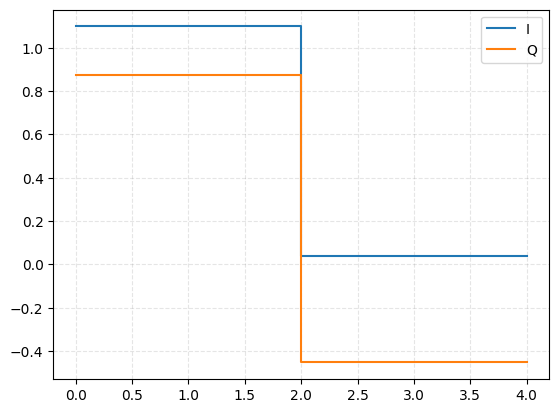

In [7]:
opt_result.plot()

In [8]:
sim_result = optimizer.simulate(
    pulse=opt_result.pulse,
    steps_per_segment=20,
)

In [9]:
sim_result.print_final_populations()

|0> :  0.00%
|1> : 100.00%


In [10]:
sim_result.unitaries[-1]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 5.44460984e-08+1.42451983e-08j -9.51056522e-01-3.09016976e-01j]
 [-9.51056510e-01-3.09017013e-01j -5.24209418e-08-2.04780090e-08j]]

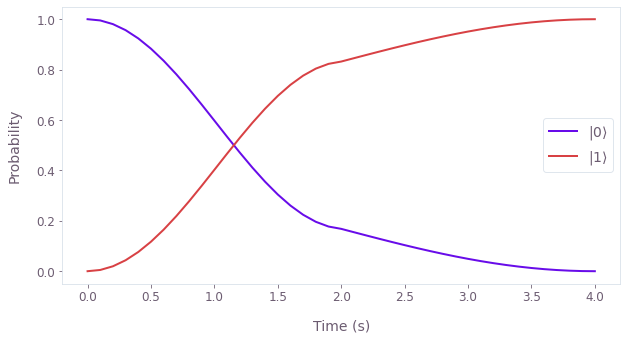

In [11]:
sim_result.plot_populations()

In [12]:
sim_result.display_bloch_sphere()

<IPython.core.display.Javascript object>

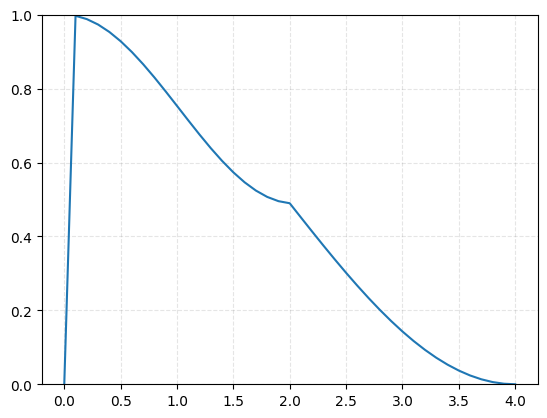

In [13]:
sim_result.plot_unitary_infidelities()

## Rx(π/2) gate 

In [14]:
target_unitary = qt.rx(np.pi / 2)
target_unitary

/var/folders/_n/h_vxv1pj18l08d2jsrv3rfv40000gn/T/ipykernel_32371/3140750525.py:1: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  target_unitary = qt.rx(np.pi / 2)


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.70710678+0.j         0.        -0.70710678j]
 [0.        -0.70710678j 0.70710678+0.j        ]]

In [15]:
target_unitary.dag() * target_unitary

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]

In [16]:
opt_result = optimizer.optimize(
    initial_params=initial_params,
    target_unitary=target_unitary,
)
opt_result

OptimizationResult(result=  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.195554766297846e-11
        x: [ 7.499e-01  1.903e+00 -1.044e+00 -1.248e+00]
      nit: 10
      jac: [ 6.407e-07 -5.960e-08  6.855e-07  1.535e-06]
 hess_inv: [[ 4.908e+00 -5.925e+00  4.101e+00  2.214e+00]
            [-5.925e+00  9.223e+00 -6.546e+00 -3.439e+00]
            [ 4.101e+00 -6.546e+00  5.356e+00  2.308e+00]
            [ 2.214e+00 -3.439e+00  2.308e+00  1.887e+00]]
     nfev: 55
     njev: 11, times=array([0., 2., 4.]), params=array([ 0.74991473,  1.90340019, -1.04446012, -1.24753477]), pulse=array([ 0.74991473+1.90340019j, -1.04446012-1.24753477j]))

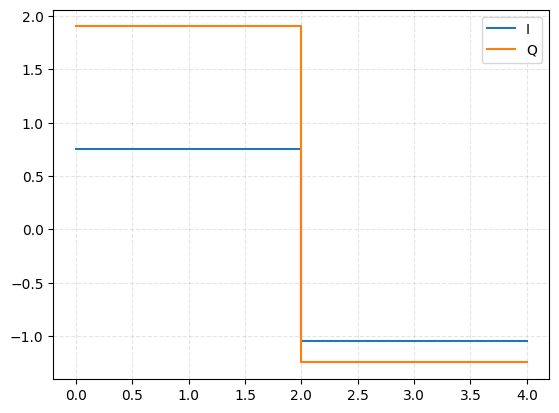

In [17]:
opt_result.plot()

In [18]:
sim_result = optimizer.simulate(
    pulse=opt_result.pulse,
    steps_per_segment=20,
)

In [19]:
sim_result.print_final_populations()

|0> : 50.00%
|1> : 50.00%


In [20]:
sim_result.unitaries[-1]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.21850581-0.67249725j -0.67249987-0.21850992j]
 [-0.67250073-0.21850727j  0.21850905-0.67249619j]]

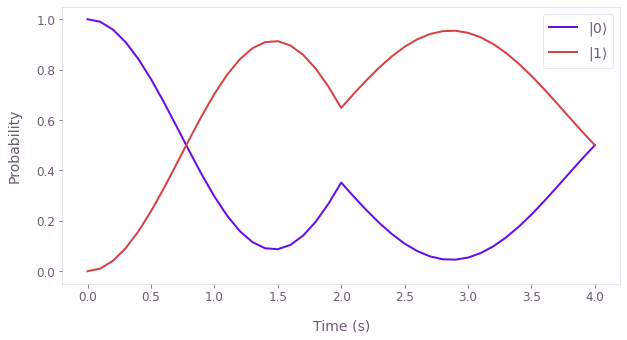

In [21]:
sim_result.plot_populations()

In [22]:
sim_result.display_bloch_sphere()

<IPython.core.display.Javascript object>

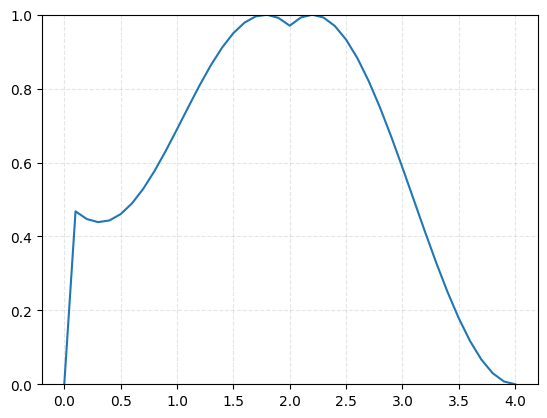

In [23]:
sim_result.plot_unitary_infidelities()

## Hadmard gate

In [24]:
optimizer = PulseOptimizer(
    dimension=2,
    detuning=0.1,
    anharmonicity=-0.3,
    segment_count=2,
    segment_width=2.0,
)

In [25]:
initial_params = optimizer.random_params()
initial_params

array([0.33897279, 0.41115869, 0.35059032, 0.10902744])

In [26]:
target_unitary = qt.Qobj(
    [
        [1, 1],
        [1, -1],
    ]
) / np.sqrt(2)
target_unitary

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]

In [27]:
target_unitary.dag() * target_unitary

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]

In [28]:
opt_result = optimizer.optimize(
    initial_params=initial_params,
    target_unitary=target_unitary,
)
opt_result

OptimizationResult(result=  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 8.046896482483135e-13
        x: [-1.340e-01  6.751e-02 -7.358e-01  3.935e-01]
      nit: 10
      jac: [-2.980e-07  1.058e-06 -3.576e-07 -2.086e-07]
 hess_inv: [[ 6.276e-01  6.309e-03 -1.088e-01  3.269e-01]
            [ 6.309e-03  8.317e-01 -4.435e-01 -1.482e-01]
            [-1.088e-01 -4.435e-01  8.579e-01  1.384e-01]
            [ 3.269e-01 -1.482e-01  1.384e-01  7.713e-01]]
     nfev: 80
     njev: 16, times=array([0., 2., 4.]), params=array([-0.1340223 ,  0.06750714, -0.7357866 ,  0.39345069]), pulse=array([-0.1340223+0.06750714j, -0.7357866+0.39345069j]))

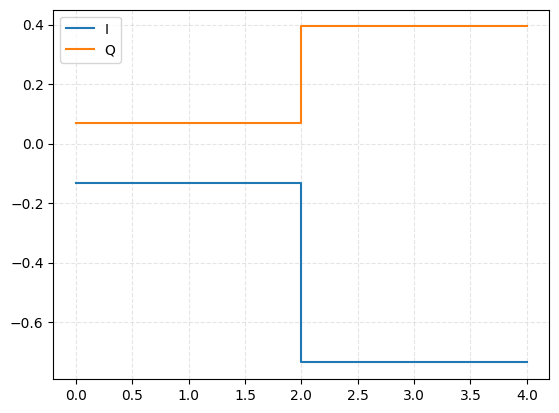

In [29]:
opt_result.plot()

In [30]:
sim_result = optimizer.simulate(
    pulse=opt_result.pulse,
    steps_per_segment=20,
)

In [31]:
sim_result.print_final_populations()

|0> : 50.00%
|1> : 50.00%


In [32]:
sim_result.unitaries[-1]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.67249857+0.21850884j  0.67249826+0.21850779j]
 [ 0.67249818+0.21850805j -0.67249904-0.21850737j]]

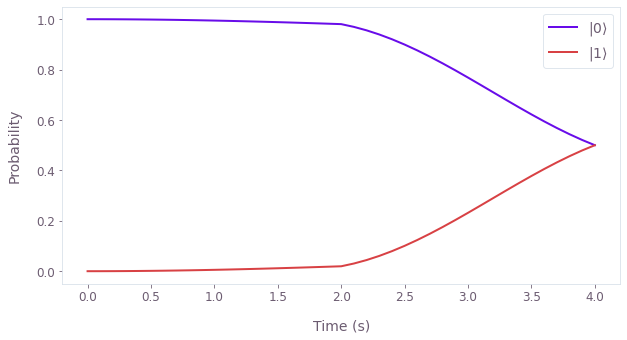

In [33]:
sim_result.plot_populations()

In [34]:
sim_result.display_bloch_sphere()

<IPython.core.display.Javascript object>

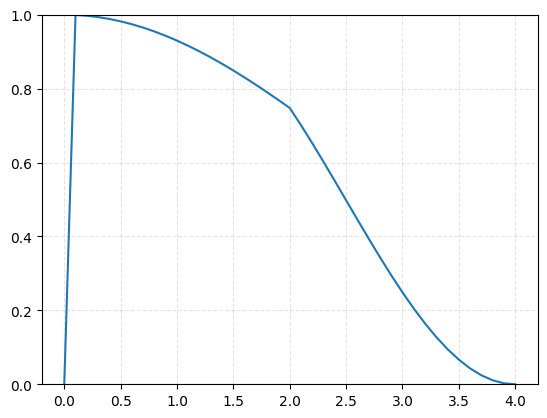

In [35]:
sim_result.plot_unitary_infidelities()